In [1]:
import pandas as pd

import numpy as np

In [18]:
df_e = pd.read_csv('english.csv')

In [19]:
df_c = pd.read_csv('chinese.csv')

In [22]:
indices = []
english = dict()
slides = []
for i, row in df_c.iterrows():
    new_dict = {}
    if isinstance(row['toc'], str):
        indices.append(i)
    new_dict['caption'] = str(row['toc'])

    if isinstance(row['two'], str):
        new_dict['one'] = {'title': row['title'], 
                           'author': row['author1'], 
                           'text': row['one']
                          }
        new_dict['two'] = {'title': row['title2'], 
                       'author': row['author2'], 
                       'text': row['two']
                      }
    else:
        new_dict['title'] = row['title']
        new_dict["author"] = row['author1']
        new_dict['text'] = row['one']
    slides.append(new_dict)
english['slides'] = slides
    

In [23]:
import json

json.dumps(english['slides'], ensure_ascii=False)


'[{"caption": "自然的声音", "title": "自然的声音", "author": "Christina Lai, Michelle Fang", "text": "探索北京的旅程，就从清晨的鸟鸣声开始吧。我们看见绿叶，闻见花香，看到灰蒙蒙的天空下大树舒展开枝桠。但我们常常看不见那些声音的缔造者。不过，我们至少还有机会仔细聆听。"}, {"caption": "nan", "title": "鸟鸣声", "author": "Arjun Sai, Eli Morimoto", "text": "点击左图，你会听到清华校园里乌鸫的啼鸣，它们也叫百舌鸟，总在立春后鸣叫不已。右下方的视频摄于后海，你需要在其中辨别清脆的鸟鸣声和电动车的报警声。在两段录音里，你都会听到「自然」和「人类生活」的混杂。"}, {"caption": "nan", "title": "京郊探险", "author": "Serge-Raymond Nzabandora", "text": "北京不仅有钢筋水泥，车水马龙。周末，我们的同学也常去探索京郊的新奇与美好。北方的水镇，生命力旺盛的野长城，莽莽山脉，落日余晖，这些是在北京城内领略不到的风光。"}, {"caption": "赛博世界", "title": "机器与人，替代？", "author": "Gurchit Chatha, Pearl Xu", "text": "机器人已经渗透进我们的生活。在宾馆，机器人可以帮你送外卖到你的房间门口。在清华校园，机器人可以帮厨师完成一些机械的削面工作。"}, {"caption": "nan", "title": "机器与人，共生？", "author": "Raven Witherspoon, Alex Zhao, Chen Xiao", "text": "机器声围绕在生活的每一刻。无论你在开车还是骑自行车，只要开了导航，语音指引会一直伴随耳畔；解锁共享单车时，单车会发出可爱的语音提示；电动三轮车倒车时也会反复叫唤：「倒车请注意」。在丰富多彩的中国生活中，眼睛要看的东西越来越多，耳朵则能帮助眼睛分担观察世界的压力。"}, {"caption": "唱啊，跳啊", "one": {"title": "「看不见」的吹奏者", "author": "Hasani Arnold", "te

In [108]:
indices = np.array(indices) + 1

In [109]:
indices

array([ 1,  4,  6,  8, 10, 11, 12, 14, 18, 19, 21, 22])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import *
import seaborn as sns
%matplotlib inline


## Helper functions

In [2]:
# converts index to unique key for each row
def makevcfkey(df):
    chrpos=[str(x)+'-'+str(y) for x,y in zip(df[0],df[1])]
    refalt=[x+'-'+y for x,y in zip(df[3],df[4])]
    keyf=[x+'-'+y for x,y in zip(chrpos,refalt)]
    return keyf

# converts phased data to dosage
def phased2dose(x):
    if x==x:
        if '|' in x:
            return np.sum([int(y) for y in x.split('|')])
        else:
            return int(x)
    else:
        return np.nan

# converts unphased data to dosage
def unphased2dose(x):
    if x==x:
        if '/' in x:
            return np.sum([int(y) for y in x.split('/')])
        else:
            return int(x)
    else:
        return np.nan

def unphased2DP(x):
    if x==x:
        if '/' in x:
            return np.sum([int(y) for y in x.split(',')[-1].split(':')])
        else:
            return int(x)
    else:
        return np.nan

def unphased2readrat(x):
    if x==x:
        if '/' in x:
            allelereads=[int(y) for y in x.split(',')[-1].split(':')]
            return allelereads[1]/np.sum(allelereads)
        else:
            return int(x)
    else:
        return np.nan
    
    
def imputed2dose(x):
    if x==x:
        return float(x.split(':')[-1])
    else:
        return np.nan
    
def imputed2call(x):
    if x==x:
        return x.split(':')[0]
    else:
        return np.nan

In [3]:
df_truth=pd.read_csv('./example/chr22_all_500.vcf',comment='#',header=None,sep='\t')
df_truth.index=makevcfkey(df_truth)

In [4]:
df_imputed=pd.read_csv('./example/chr22_imputed_500.vcf',comment='#',header=None,sep='\t')
df_imputed.index=makevcfkey(df_imputed)

## Todo

## Caveats

* didn't unphase data before imputation


## Things to Resolve do next

* why are there only a subset of variants overlapping (looks like fewer in imputed than truth)
* try with different amounts of downsampling
* evaluate sensitivity/specifity/R^2 as a function these three things

- MAF / AF = allelefrequency
- sex
- ethnicity

* rando duplicated - index? - one row - nbd



In [5]:
df_truth = df_truth.iloc[~df_truth.index.duplicated(), :]
df_imputed = df_imputed.loc[~df_imputed.index.duplicated(), :]

In [6]:
## select variants in both the imputed and original
inboth=list(set(df_truth.index).intersection(df_imputed.index))

In [7]:
# retrieves only data by excluding initial columns

df_truth_data_only = df_truth.loc[inboth].iloc[:,9:]
df_imputed_data_only = df_imputed.loc[inboth].iloc[:,9:]

In [8]:
assert len(df_truth_data_only) == len(df_imputed_data_only)

In [9]:
## check that there are no duplicate rows

assert df_truth_data_only.index.duplicated().sum() == 0
assert df_imputed_data_only.index.duplicated().sum() == 0

In [10]:
# set flag if variant was imputed
IMPUTED_FLAG = df_imputed[7].str.contains('IMPUTED').loc[inboth]

In [41]:
def calc_corr_coeff(df_truth_data_only, df_imputed_data_only, imputed_flag):

    # convert phased data to dosages

    dftruthdose=[]
    for col in df_truth_data_only.columns:
        dftruthdose.append(df_truth_data_only[col].apply(lambda x: phased2dose(x)))

    df_truthdose=pd.concat(dftruthdose,axis=1)

    # convert phased data to dosages

    dfimputeddose=[]
    for col in df_imputed_data_only.columns:
        dfimputeddose.append(df_imputed_data_only[col].apply(lambda x: imputed2dose(x)))

    df_imputeddose=pd.concat(dfimputeddose,axis=1)
    
    flatimputed = df_imputeddose[IMPUTED_FLAG].values.flatten()
    flattruth = df_truthdose[IMPUTED_FLAG].values.flatten()
    corr_imputed = np.corrcoef(flatimputed,flattruth)
    
    flatimputed=df_imputeddose[~IMPUTED_FLAG].values.flatten()
    flattruth=df_truthdose[~IMPUTED_FLAG].values.flatten()
    corr_not_imputed = np.corrcoef(flatimputed,flattruth)
    
    return corr_imputed, corr_not_imputed

### correlation coeff

In [102]:
corr_100k = corr

In [ ]:
corr = calc_corr_coeff(df_truth_data_only, df_imputed_data_only, IMPUTED_FLAG)

In [43]:
print(corr[0])
print(corr[1])

[[1.         0.95984977]
 [0.95984977 1.        ]]
[[1.         0.99225287]
 [0.99225287 1.        ]]


## confusion matrix

In [ ]:
## calculates confusion matrix for all data (both imputed and not)

In [11]:
import time

In [19]:
def calc_confusion_f1(df_truth_data_only, df_imputed_data_only, imputed_flag):
    """
    Function to return confusion matrix and f1 score.
    
    df_truth_data_only : pd.DataFrame
        df_truth contains the true values for the data. 
        df_truth contains only data, not the first few columns of metadata.
    df_imputed_data_only : pd.DataFrame
        df_imputed contains imputed values.
    imputed_flag : Series
        imputed_flag contains which rows were imputed variants.
    
    """

    # convert imputed values to just the predicted class
    start = time.time()
    dfimputedcall=[]
    for col in df_imputed_data_only.columns:
        dfimputedcall.append(df_imputed_data_only[col].apply(lambda x: imputed2call(x)))
    print("Time to process imputed columns", time.time() - start)
    start = time.time()

    df_imputedcall = pd.concat(dfimputedcall, axis=1)
    
    truth = df_truth_data_only.values.flatten()
    preds = df_imputedcall.values.flatten()

    # merge 1|0 and 0|1 preds
    truth = ['0|1' if elem == '1|0' else elem for elem in truth]
    preds = ['0|1' if elem == '1|0' else elem for elem in preds]
    print("Time to flatten", time.time() - start)
    start = time.time()
    """

    labelvec = np.unique(truth)
    
    # confusion matrix for all values
    CONF = sklearn.metrics.confusion_matrix(truth, preds)
    print("Time to calc confusion matrix", time.time() - start)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    df_CONF=pd.DataFrame(CONF)
    df_CONF.index=labelvec
    df_CONF.columns=labelvec

    plt.title("Confusion matrix for all data (imputed/non-imputed)")
    df_NORM= df_CONF / df_CONF.sum()
    sns.heatmap(np.log10(df_NORM))
    
    truth = df_truth_data_only[imputed_flag].values.flatten()
    preds = df_imputedcall[imputed_flag].values.flatten()

    # merge 1|0 and 0|1 preds
    truth = ['0|1' if elem == '1|0' else elem for elem in truth]
    preds = ['0|1' if elem == '1|0' else elem for elem in preds]

    CONF = sklearn.metrics.confusion_matrix(truth, preds)
    
    # confusion matrix for imputed values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 2)
    df_CONF=pd.DataFrame(CONF)
    df_CONF.index=labelvec
    df_CONF.columns=labelvec

    sns.heatmap(np.log10(df_CONF))
    ## calculate weighted f1 score for just imputed values
    """
    return sklearn.metrics.f1_score(truth, preds, average='macro')

In [20]:
f1_score_100k = 0.9819091196583315

In [ ]:
f1_score = calc_confusion_f1(df_truth_data_only, df_imputed_data_only, IMPUTED_FLAG)

## check demographic data

In [46]:
# to do: need right header

In [47]:
df_sampleinfo=pd.read_csv('./example/sample_info.csv')

In [48]:
# collect header info with individual IDs

header = np.loadtxt('header.txt', dtype=str, comments='##', delimiter='/t')
header = np.expand_dims(header, axis=0)
header = header[0].split('\t')

In [49]:
df_sex = dict()
df_popul = dict()
df_super_popul = dict()

In [50]:
for col in df_imputed_data_only.columns:
    row = df_sampleinfo[df_sampleinfo['Sample'] == header[col]]
    df_sex[col] = row['Gender'].values[0]
    df_popul[col] = row['Population'].values[0]
    df_super_popul[col] = row['Super_Population'].values[0]

In [52]:
sex = list(set(df_sex.values()))
popul = list(set(df_popul.values()))
super_pop = list(set(df_super_popul.values()))

['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']
['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']
['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']
['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']


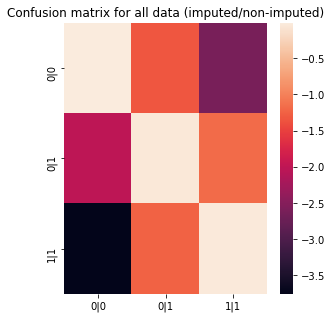

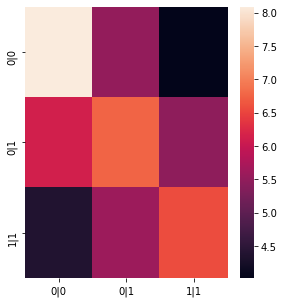

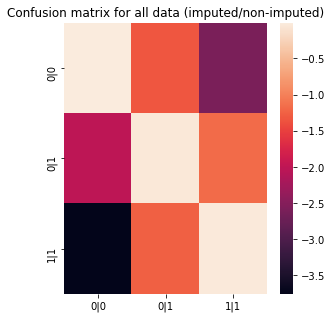

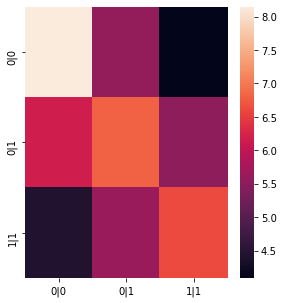

In [56]:


sex_f1_scores = []
for elem in sex:
    cols = [col for col in df_imputed_data_only.columns if df_sex[col] == elem]
    sex_f1_scores.append(calc_confusion_f1(df_truth_data_only[cols], df_imputed_data_only[cols], IMPUTED_FLAG))

Text(-0.1, 0.982, '0.9819')

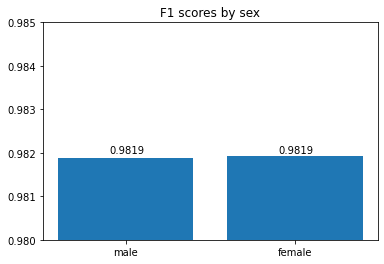

In [100]:
plt.bar(range(2), sex_f1_scores)
plt.xticks(range(2), labels=sex)
plt.ylim(0.98, 0.985)
plt.title("F1 scores by sex")
plt.annotate(round(sex_f1_scores[1], 4), (0.9, 0.982))
plt.annotate(round(sex_f1_scores[0], 4), (-0.1, 0.982))

[315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329]
['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']
['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']
[194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305]
['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']
['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 81, 82, 83

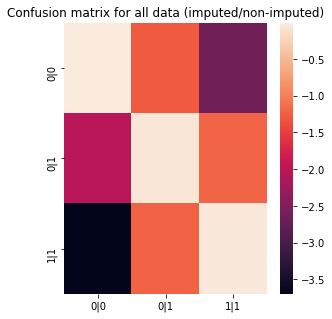

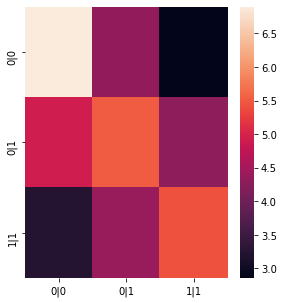

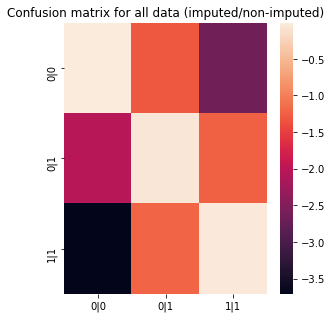

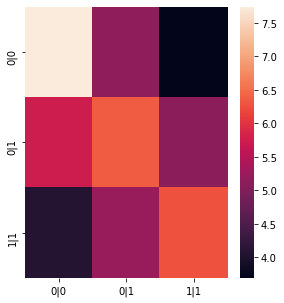

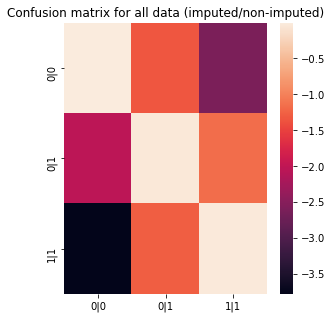

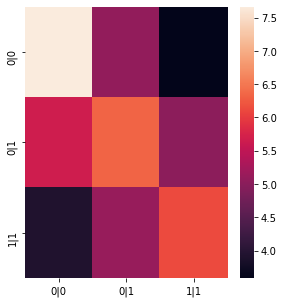

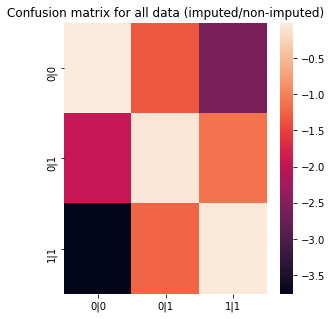

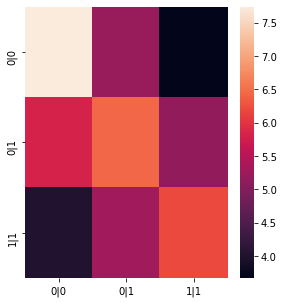

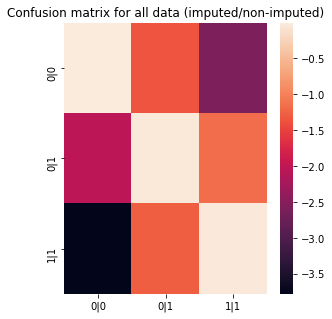

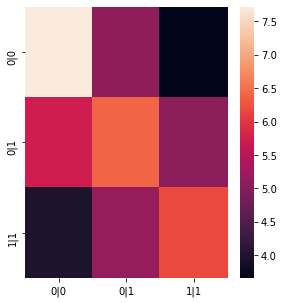

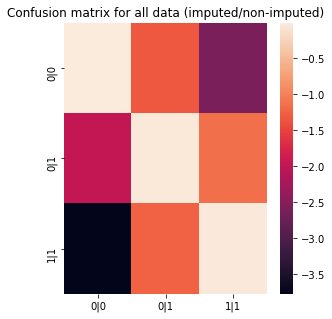

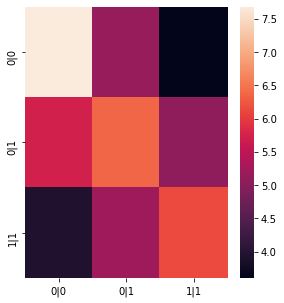

In [66]:
popul_f1_scores = []
for elem in popul:
    cols = [col for col in df_imputed_data_only.columns if df_popul[col] == elem]
    print(cols)
    if cols:
        popul_f1_scores.append(calc_confusion_f1(df_truth_data_only[cols], df_imputed_data_only[cols], IMPUTED_FLAG))

In [73]:
len(set(df_popul.values()))

6

In [76]:
popul_f1_scores

[0.9822004596545746,
 0.9829470992793864,
 0.9829550055470481,
 0.9798093911780811,
 0.9828830031462195,
 0.9809982977028763]

In [75]:
popul

['CDX', 'CHS', 'GBR', 'PUR', 'FIN', 'CLM']

Text(0.5, 1.0, 'F1 scores for different populations')

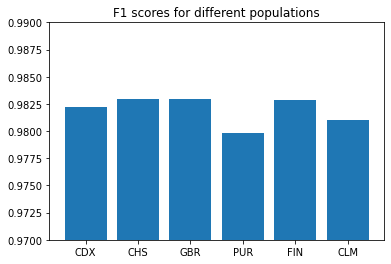

In [87]:
plt.bar(range(6), popul_f1_scores)
plt.xticks(range(6), labels=popul)
plt.ylim(0.97, 0.99)
plt.title('F1 scores for different populations')

['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']
['0|0' '0|0' '0|0' ... '0|0' '0|0' '0|0']


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-67-bd26d134a64a>", line 5, in <module>
    super_f1_scores.append(calc_confusion_f1(df_truth_data_only[cols], df_imputed_data_only[cols], IMPUTED_FLAG))
  File "<ipython-input-44-3d4b2cbbc8fc>", line 53, in calc_confusion_f1
    CONF = sklearn.metrics.confusion_matrix(truth, preds)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 293, in confusion_matrix
    y_pred = np.array([label_to_ind.get(x, n_labels + 1) for x in y_pred])
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 293, in <listcomp>
    y_pred = np.array([label_to_ind.get(x, n_labels + 1) for x in y_pred])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fil

KeyboardInterrupt: 

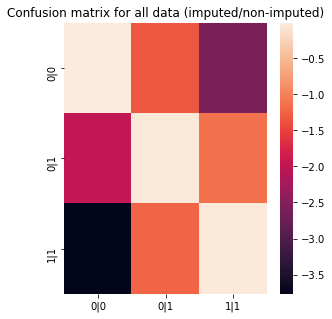

In [ ]:
super_f1_scores = []
for elem in super_pop:
    cols = [col for col in df_imputed_data_only.columns if df_super_popul[col] == elem]
    if cols:
        super_f1_scores.append(calc_confusion_f1(df_truth_data_only[cols], df_imputed_data_only[cols], IMPUTED_FLAG))

## allele frequency effect on accuracy

In [ ]:
## calculate allele freq

x = np.log10(df_truthdose.mean(axis=1) + 0.0002) / 2

In [ ]:
intervals = pd.cut(x, 10, retbins=True)

intervals[-1]